### Plot a batch of neural activty sequences from train and test datasets.
---
*Last updated: 26 October 2023*

In [1]:
import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import TwoSlopeNorm
from data._utils import generate_all_subsets
from utils import NEURONS_302, init_random_seeds
from matplotlib.collections import LineCollection

MPS device found.


In [2]:
seed = 42
init_random_seeds(seed)

datadir = "datasets/combined_experiment_datasets"
file = os.path.join(datadir, "combined_dataset.pickle")
combined_data = pickle.load(open(file, "rb"))

num_worms = len(combined_data.keys())
print(f"number of worms: {num_worms}", end="\n\n")

for key in combined_data["worm0"]:
    print(key)

number of worms: 235

dataset
smooth_method
interpolate_method
worm
original_calcium_data
original_smooth_calcium_data
calcium_data
smooth_calcium_data
residual_calcium
original_residual_calcium
smooth_residual_calcium
original_smooth_residual_calcium
max_timesteps
original_max_timesteps
original_time_in_seconds
time_in_seconds
dt
original_median_dt
resample_median_dt
num_neurons
num_named_neurons
num_unknown_neurons
named_neurons_mask
unknown_neurons_mask
neurons_mask
slot_to_named_neuron
named_neuron_to_slot
slot_to_unknown_neuron
unknown_neuron_to_slot
slot_to_neuron
neuron_to_slot
original_dt
original_worm


In [ ]:
# # DEBUG testing generating subsets
# all_possible_subsets = generate_all_subsets(combined_data)

In [3]:
# Choose the train or test dataset
train_or_test = "train"
if train_or_test.lower() == "train":
    dataset = torch.load(os.path.join(datadir, "train_dataset.pt"))
elif train_or_test.lower() == "test":
    dataset = torch.load(os.path.join(datadir, "val_dataset.pt"))

# Get the first batch of data
X, Y, mask, meta = next(iter(dataset))

# Select the measure neurons using the mask
neurons = np.array(NEURONS_302)[mask]
print("neurons", neurons.shape)

# Convert tensor to numpy for easier handling
data = X[:, mask].numpy()
print("data", data.shape)

# Time or index - replace this with actual time if needed
time = meta["time_vec"].numpy()
print("time", time.shape)

neurons (45,)
data (200, 45)
time (200,)


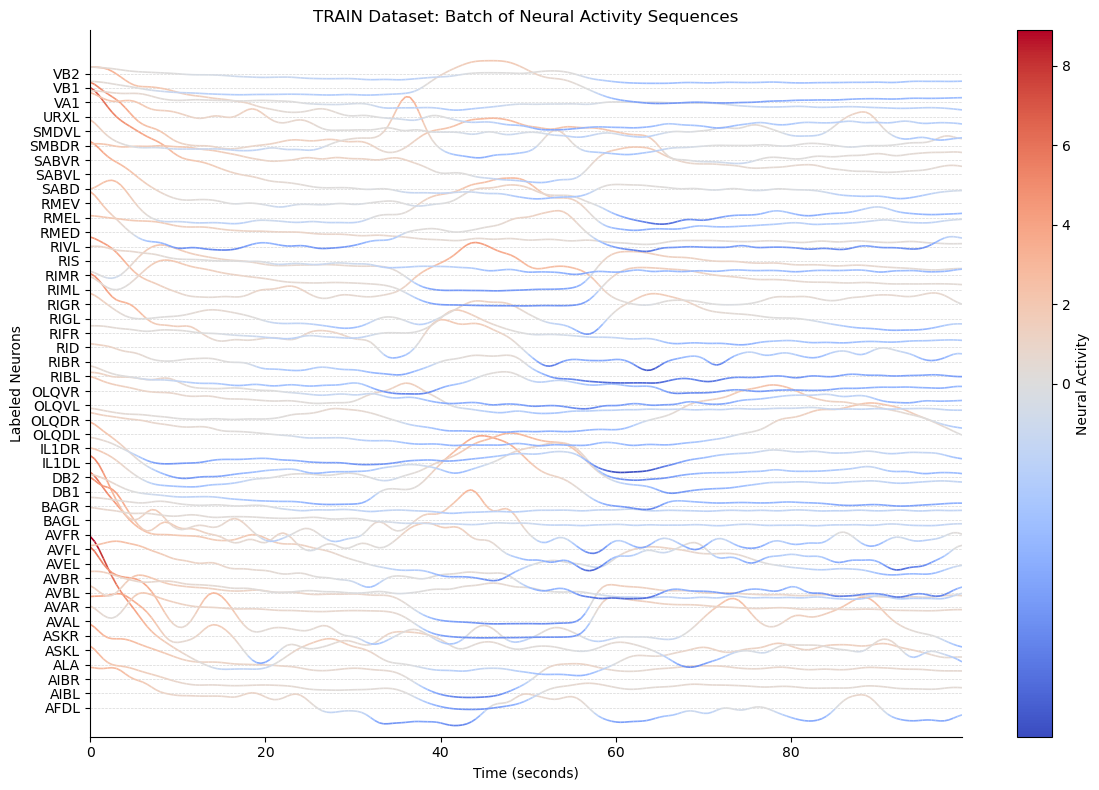

In [4]:
# Set figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define colormap
cmap = plt.get_cmap("coolwarm")

# Find the maximum and minimum magnitude of neural activity across all neurons for normalization
max_activity = np.max(data)
min_activity = np.min(data)

# Normalize the colors with a center at zero
norm = TwoSlopeNorm(vcenter=0, vmin=min_activity, vmax=max_activity)

# Iterate through each neuron and create colored lines
offset = 1.0
segments = []
colors = []

for i in range(data.shape[1]):
    for j in range(len(time) - 1):
        segment = [
            (time[j], data[j, i] + i * offset),
            (time[j + 1], data[j + 1, i] + i * offset),
        ]
        segments.append(segment)

        color = cmap(norm(data[j, i]))
        colors.append(color)

# Create a LineCollection from segments and set the colors
lc = LineCollection(segments, colors=colors, linewidth=1.2)
ax.add_collection(lc)

# Set the limits of the plot
ax.set_xlim(time[0], time[-1])
ax.set_ylim(-2 * offset, (data.shape[1] + 2) * offset)

# Set yticks and other aesthetics
ytick_positions = [i * offset for i in range(data.shape[1])]
ax.set_yticks(ytick_positions)
ax.set_yticklabels(neurons, fontsize=10)
ax.grid(axis="y", which="both", linestyle="--", linewidth=0.5, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Labeled Neurons")
ax.set_title(f"{train_or_test.upper()} Dataset: Batch of Neural Activity Sequences")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Neural Activity")

# Show the plot
plt.tight_layout()
plt.show()

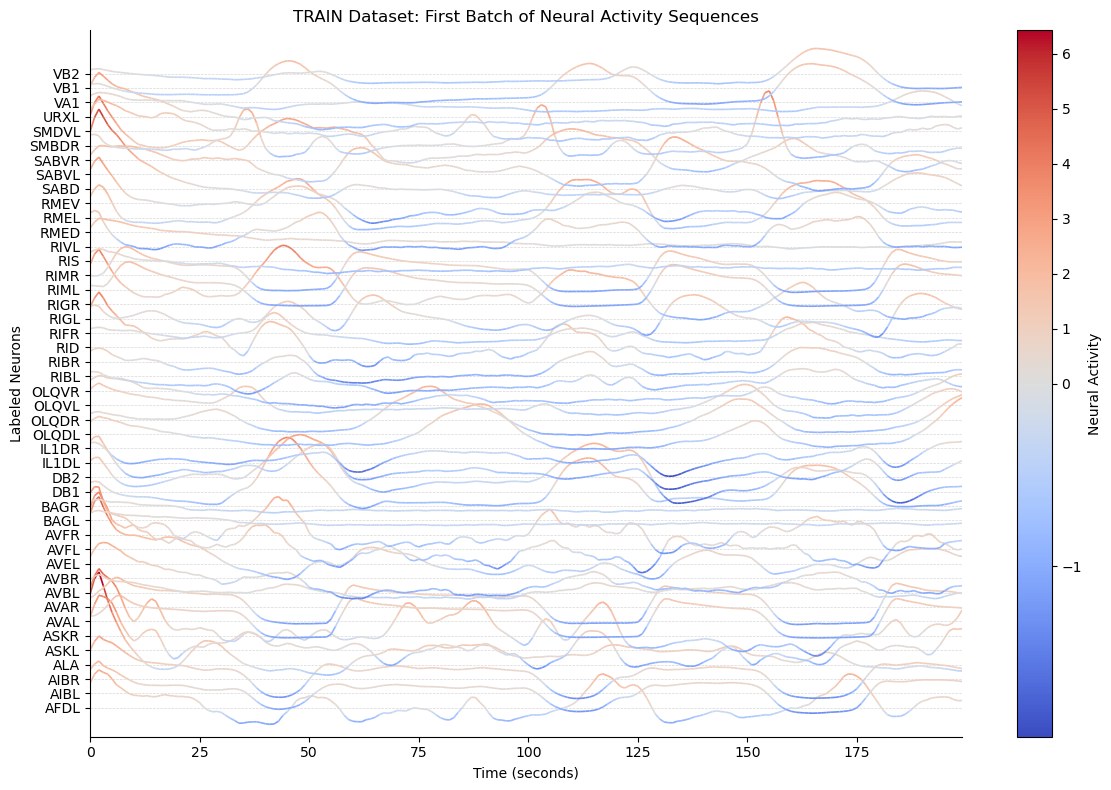

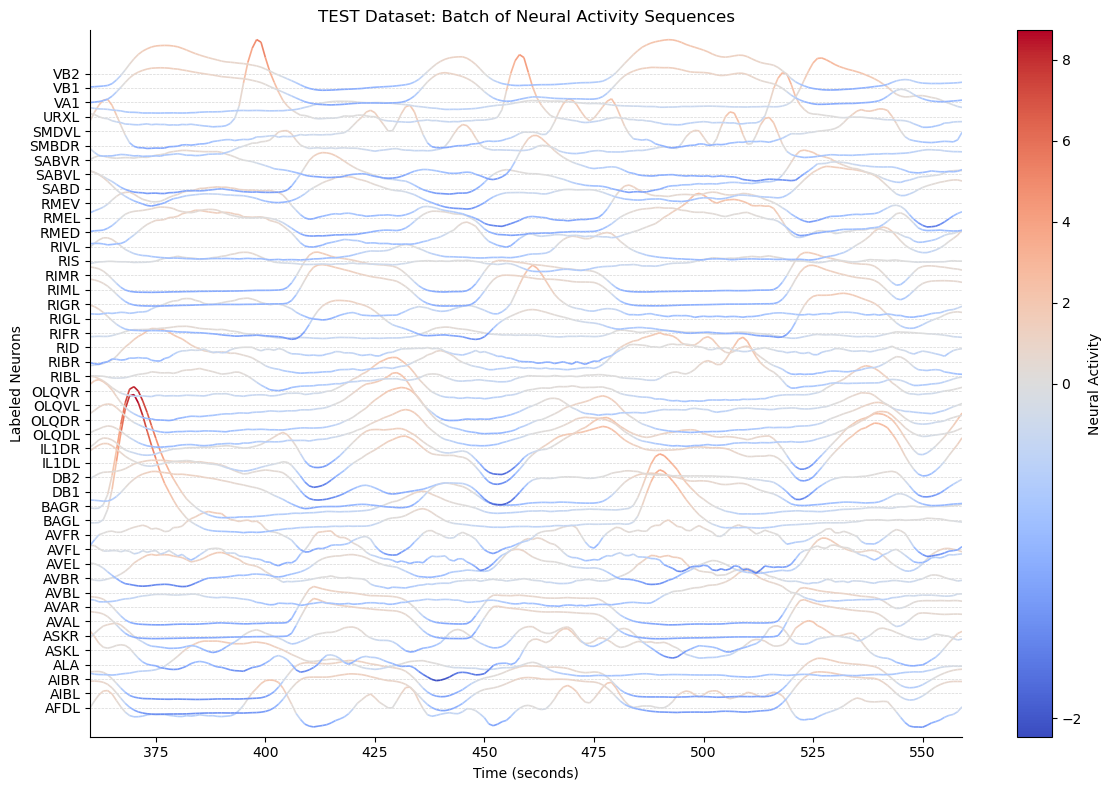